In [ ]:
# Changed data transforms
# Changed regularisation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Upload the zip file of the dataset
# !unzip -q -u "/content/drive/MyDrive/2. SUTD/SUTD Term 8/50.021 Artificial Intelligence /fish_are_mans_friend/data/train.zip" -d "/content/train"
!unzip -q -u "/content/drive/MyDrive/fish_are_mans_friend/data/train.zip" -d "/content/train"

In [3]:
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set_theme()
import glob     
import numpy as np
from PIL import Image
from collections import Counter
import os
import shutil

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split, Dataset
from torchsummary import summary
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
import torch
# Speeds up convolutions by trying different algorithms for computing convolutions
torch.backends.cudnn.benchmark = True

# Load the data path to images
# Rmb to upload the zip with the images (it is faster this way)
IMG_DIR = '/content/train/'

# Batch Size
BATCH_SIZE = 16

# Label Map
label_map = {
    0: "ALB",
    1: "BET",
    2: "DOL",
    3: "LAG",
    4: "NoF",
    5: "OTHER",
    6: "SHARK",
    7: "YFT",
}

# We will assume that all images are of .jpg and .png extensions

In [4]:
# For using our pre-trained model VGG16, we need to ensure that we use the exact same pre-processing steps

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load the training and validation dataset
try:  
#   dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
  dataset = datasets.ImageFolder(IMG_DIR)
  print(dataset)  
except FileNotFoundError:
  raise Exception("Try running cd train and rm -r .ipynb_checkpoints as it causing confusion https://stackoverflow.com/questions/68229246/pytorch-torchvision-datasets-imagefolder-filenotfounderror-found-no-valid-file") 

CLASSES = list(set(dataset.targets))
print([label_map[i] for i in CLASSES])

# randomly split train and validation data, we could also do a simple splice of 0.5 train - 0.5 validate.
valid_split = 0.2
data_size = len(dataset)
valid_size =  int(data_size * valid_split)
train_size =  data_size - valid_size

train_dataset, valid_dataset = random_split(dataset, [train_size,valid_size],generator=torch.Generator().manual_seed(42))


class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)


train_dataset = CustomDataset(train_dataset, train_transform)
valid_dataset = CustomDataset(valid_dataset, val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = 8, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers = 8, pin_memory=True)

Dataset ImageFolder
    Number of datapoints: 3777
    Root location: /content/train/
['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1428: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1443: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  "The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/fre

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


index:  0 0


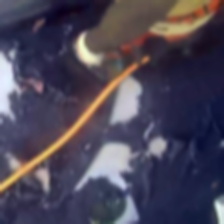

tensor(1)
index:  0 1


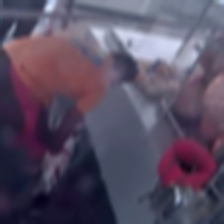

tensor(3)
index:  1 0


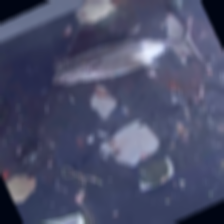

tensor(0)
index:  1 1


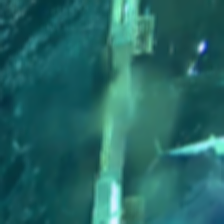

tensor(5)
index:  2 0


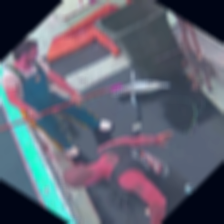

tensor(0)
index:  2 1


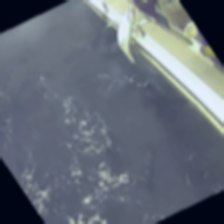

tensor(0)
index:  3 0


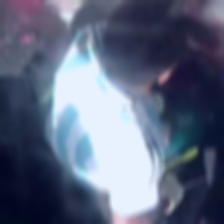

tensor(7)
index:  3 1


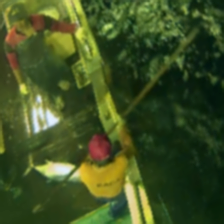

tensor(0)
index:  4 0


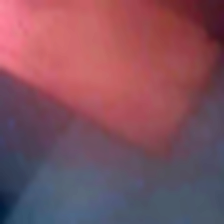

tensor(4)
index:  4 1


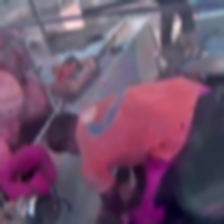

tensor(0)
index:  5 0


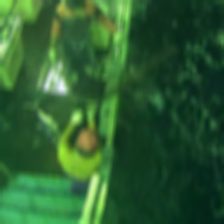

tensor(0)
index:  5 1


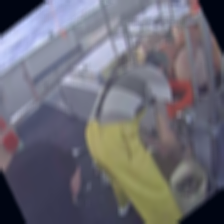

tensor(4)
index:  6 0


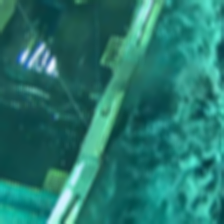

tensor(0)
index:  6 1


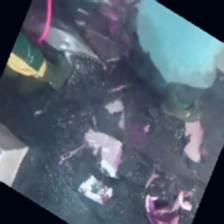

tensor(0)
index:  7 0


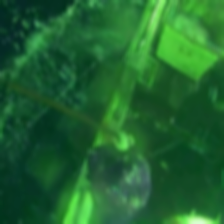

tensor(0)
index:  7 1


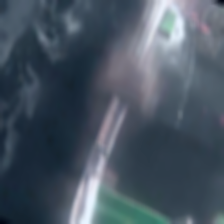

tensor(4)
index:  8 0


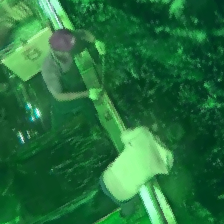

tensor(0)
index:  8 1


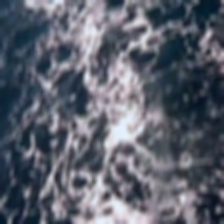

tensor(7)
index:  9 0


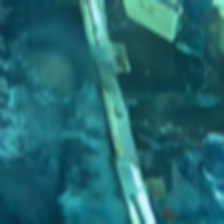

tensor(0)
index:  9 1


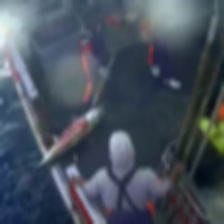

tensor(7)
index:  10 0


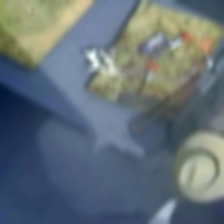

tensor(6)
index:  10 1


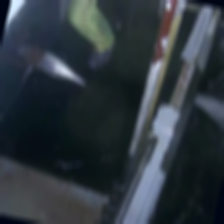

tensor(0)
index:  11 0


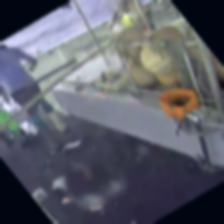

tensor(0)
index:  11 1


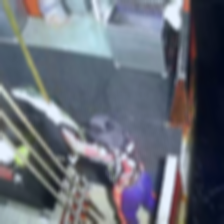

tensor(2)
index:  12 0


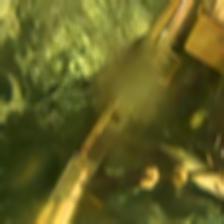

tensor(7)
index:  12 1


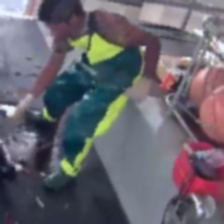

tensor(7)
index:  13 0


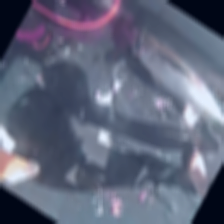

tensor(7)
index:  13 1


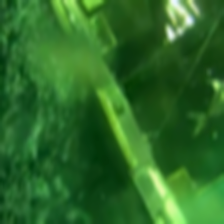

tensor(5)
index:  14 0


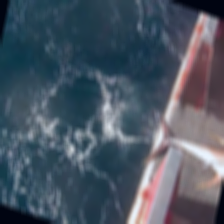

tensor(7)
index:  14 1


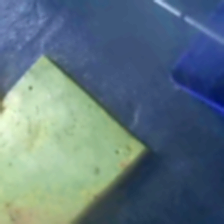

tensor(0)


In [5]:
from google.colab.patches import cv2_imshow
import cv2

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
a = 0
for i in train_dataloader:
    for j in range(len(i)):
        print("index: ", a, j)
        img = i[0][j].numpy().transpose((1, 2, 0))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2_imshow(img)
        print(i[1][j])

    a += 1
    if a == 15:
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


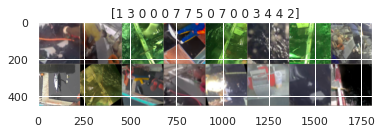

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrows=20)
imshow(out,title=classes.numpy())

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
# utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

print(efficientnet)

cuda


/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: p

  0%|          | 0.00/74.5M [00:00<?, ?B/s]

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=48, out_features=12, bias=True)
          (expand): Linear(in_features=12, out_features=48, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
    

In [8]:
def weight_builder(label_map,data_size):
  weights = []
  normalised_weights = []
  asdf = 0
  for value in label_map.values():
    weights.append(1/(len(glob.glob(f"{IMG_DIR}/{value}/*"))/data_size))
  normalised_weights = [weight/sum(weights) for weight in weights]
  return normalised_weights

In [9]:
# Freeze model parameters because they were trained already
for param in efficientnet.parameters():
    param.requires_grad = False

# Change the final layer of Model for Transfer Learning
# Here the size of each output sample is set to 8
def augment_model(efficientnet):
    efficientnet.classifier[-1] = nn.Linear(in_features=1792, out_features=len(label_map), bias=True)
    return efficientnet

efficientnet = augment_model(efficientnet)

efficientnet = efficientnet.to(device)
# Create weights to handle class imbalance
weights = weight_builder(label_map,data_size)
# added weights to crossentropyloss for class imbalance
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).to(device))
# We will use ADAM as our opitimiser
# Add regularisation
optimizer_ft = optim.Adam(efficientnet.parameters(), lr=0.001, weight_decay=1e-5)
# Exponentially Decay LR by a factor of 0.1
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
# # Test dataloader speed
# for index, i in enumerate(train_dataloader):
#     print(index, end=", ")
#     if index % 20 == 0:
#         print()

In [11]:
import copy
import time
plot_train_acc = []
plot_train_loss = []
plot_val_acc = []
plot_val_loss = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_dataloader
                dataset_size = valid_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            if phase == 'train':
                plot_train_loss.append(float(epoch_loss))
                plot_train_acc.append(float(epoch_acc))
            if phase == 'val':
                plot_val_loss.append(float(epoch_loss))
                plot_val_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

efficientnet_classifier_done = train_model(efficientnet, loss_fn, optimizer_ft, exp_lr_scheduler,
                               num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.8734 Acc: 0.2763
val Loss: 1.6757 Acc: 0.3020

Epoch 1/9
----------
train Loss: 1.6332 Acc: 0.3177
val Loss: 1.5997 Acc: 0.3205

Epoch 2/9
----------
train Loss: 1.4967 Acc: 0.3481
val Loss: 1.5429 Acc: 0.3523

Epoch 3/9
----------
train Loss: 1.4403 Acc: 0.3670
val Loss: 1.5120 Acc: 0.3377

Epoch 4/9
----------
train Loss: 1.3905 Acc: 0.3766
val Loss: 1.4970 Acc: 0.3735

Epoch 5/9
----------
train Loss: 1.3468 Acc: 0.4103
val Loss: 1.4912 Acc: 0.3523

Epoch 6/9
----------
train Loss: 1.3340 Acc: 0.3974
val Loss: 1.4570 Acc: 0.3589

Epoch 7/9
----------
train Loss: 1.3178 Acc: 0.4298
val Loss: 1.4375 Acc: 0.3589

Epoch 8/9
----------
train Loss: 1.2870 Acc: 0.4255
val Loss: 1.4496 Acc: 0.3483

Epoch 9/9
----------
train Loss: 1.2711 Acc: 0.4295
val Loss: 1.4384 Acc: 0.3536

Training complete in 23m 4s
Best val Acc: 0.373510


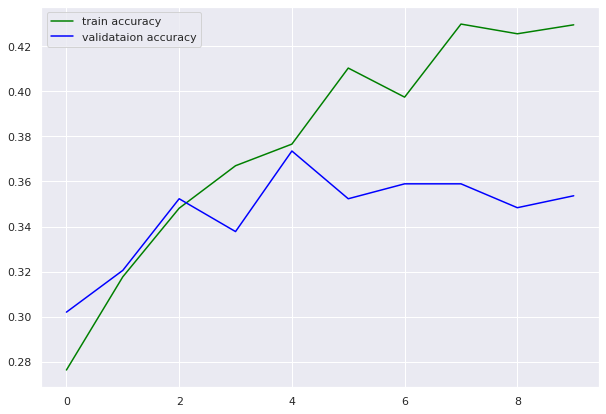

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('./images/train_val_accuracy.png')
plt.show()

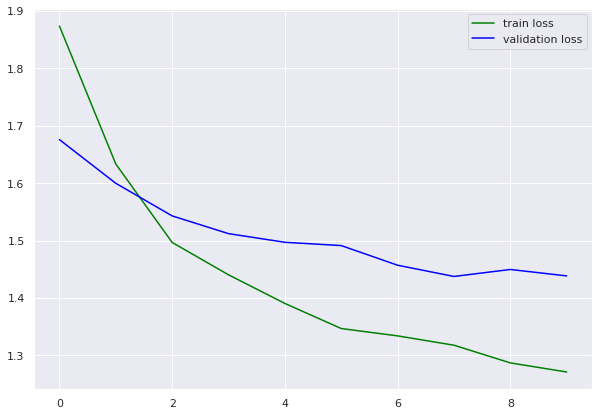

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_loss, color='green', label='train loss')
plt.plot(plot_val_loss, color='blue', label='validation loss')
plt.legend()
plt.savefig('./images/train_val_loss.png')
plt.show()

In [15]:
# Train the model as a whole
for param in efficientnet.parameters():
    param.requires_grad = True

# We will use ADAM as our opitimiser
# Add regularisation
optimizer_final = optim.Adam(efficientnet.parameters(), lr=0.001, weight_decay=1e-5)
# Exponentially Decay LR by a factor of 0.1
exp_lr_scheduler_final = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

efficientnet_final = train_model(efficientnet_classifier_done, loss_fn, optimizer_final, 
                                 exp_lr_scheduler_final, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.2382 Acc: 0.4643


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss: 2.3920 Acc: 0.4940

Epoch 1/24
----------
train Loss: 0.7305 Acc: 0.6486
val Loss: 1.7451 Acc: 0.4623

Epoch 2/24
----------
train Loss: 0.6676 Acc: 0.6711
val Loss: 0.6382 Acc: 0.6834

Epoch 3/24
----------
train Loss: 0.5663 Acc: 0.7310
val Loss: 0.8110 Acc: 0.6636

Epoch 4/24
----------
train Loss: 0.3516 Acc: 0.8071
val Loss: 0.4798 Acc: 0.8212

Epoch 5/24
----------
train Loss: 0.2748 Acc: 0.8614
val Loss: 0.6044 Acc: 0.7669

Epoch 6/24
----------
train Loss: 0.2516 Acc: 0.8643
val Loss: 0.8370 Acc: 0.7444

Epoch 7/24
----------
train Loss: 0.3523 Acc: 0.8382
val Loss: 0.8019 Acc: 0.7046

Epoch 8/24
----------
train Loss: 0.3540 Acc: 0.8236
val Loss: 0.7628 Acc: 0.7205

Epoch 9/24
----------
train Loss: 0.3001 Acc: 0.8577
val Loss: 0.8713 Acc: 0.7219

Epoch 10/24
----------
train Loss: 0.2247 Acc: 0.8769
val Loss: 0.9396 Acc: 0.5868

Epoch 11/24
----------
train Loss: 0.1330 Acc: 0.9196
val Loss: 0.5202 Acc: 0.8702

Epoch 12/24
----------
train Loss: 0.1455 Acc: 0.9262
v

In [16]:
# If the above meet into cuda memory errors, run the following to clear some memory
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

2856

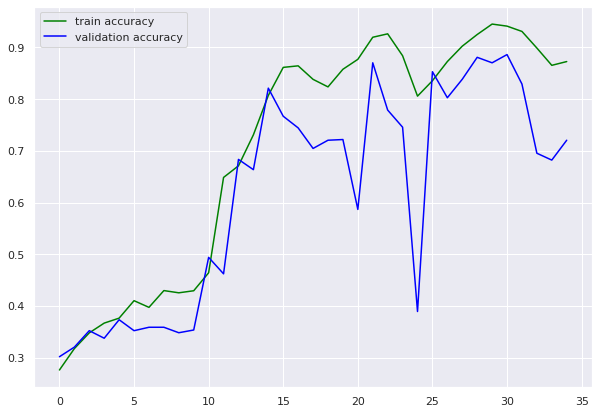

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validation accuracy')
plt.legend()
plt.savefig('./images/train_val_accuracy_final.png')
plt.show()

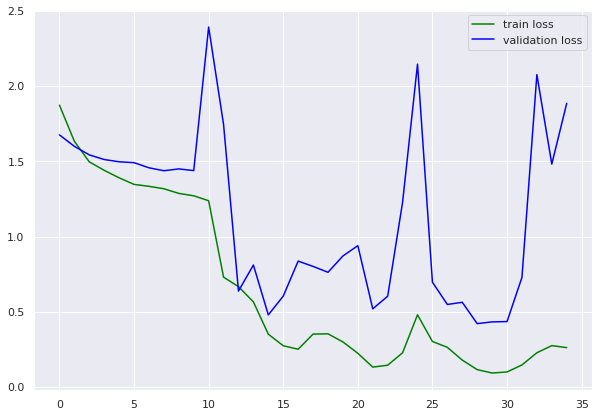

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_loss, color='green', label='train loss')
plt.plot(plot_val_loss, color='blue', label='validation loss')
plt.legend()
plt.savefig('./images/train_val_loss_final.png')
plt.show()

In [20]:
# save_path = "/content/drive/MyDrive/2. SUTD/SUTD Term 8/50.021 Artificial Intelligence /fish_are_mans_friend/models/efficientnet_02_full.pt"
save_path = "/content/drive/MyDrive/fish_are_mans_friend/models/efficientnet_02_full.pt"

torch.save(efficientnet_final, save_path)

In [ ]:
load_path = ;

efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)

model = augment_model(efficientnet)
model.load_state_dict(torch.load(PATH))
model.eval()